In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# PCA（主成分分析）

如果不存在无用特征，PCA将损失很多信息，PCA的主要思想是投影。

可解释方差比越大越好，代表该维度保留了较多的数据特征

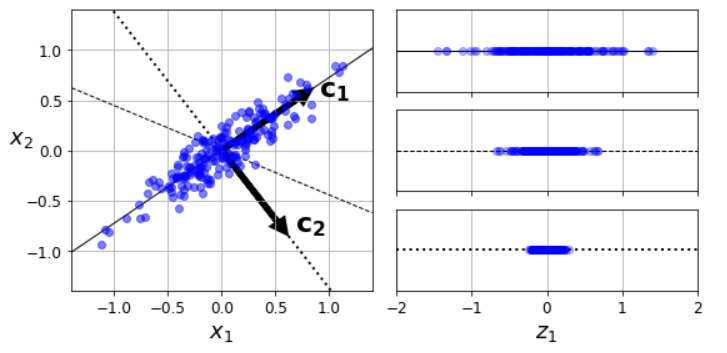

In [2]:
m = 60
w1, w2 = 0.1, 0.3
noise = 0.1

angles = np.random.rand(m) * 3 * np.pi / 2 - 0.5
x = np.empty((m, 3))
x[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * np.random.randn(m) / 2
x[:, 1] = np.sin(angles) * 0.7 + noise * np.random.randn(m) / 2
x[:, 2] = x[:, 0] * w1 + x[:, 1] * w2 + noise * np.random.randn(m)

# 3D数据集

In [3]:
x[:10, :]

array([[ 0.7039474 ,  0.65945649,  0.3645693 ],
       [-1.0763742 , -0.50036633, -0.21646923],
       [-0.90914129,  0.22798983,  0.05968884],
       [-0.26327638,  0.52076062,  0.31957985],
       [ 1.10617261,  0.17601773,  0.13888377],
       [ 1.0008109 ,  0.15934054,  0.07250963],
       [ 0.87852969, -0.25299137, -0.07699588],
       [-1.13697989, -0.29958862, -0.2851556 ],
       [-0.36237145,  0.50948368,  0.10889779],
       [-0.7732104 ,  0.3332867 ,  0.05678017]])

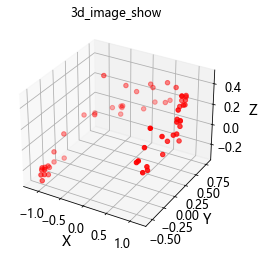

In [4]:
ax = plt.subplot(projection = '3d')  # 创建一个三维的绘图工程
ax.set_title('3d_image_show')  # 设置本图名称
ax.scatter(x[:, 0], x[:, 1], x[:, 2], c = 'r')   # 绘制数据点 c: 'r'红色，'y'黄色，等颜色

ax.set_xlabel('X')  # 设置x坐标轴
ax.set_ylabel('Y')  # 设置y坐标轴
ax.set_zlabel('Z')  # 设置z坐标轴

plt.show()

## 主要成分

In [5]:
x_centered = x - x.mean(axis=0)  # 居中处理
y, s, vt = np.linalg.svd(x_centered)  # np的svd()函数获取训练集的主要成分
c1 = vt.T[:, 0]
c2 = vt.T[:, 1]

In [6]:
c1, c2

(array([-0.95250178, -0.24902446, -0.17529172]),
 array([ 0.29267159, -0.9076305 , -0.30091563]))

## 向下投影到d维度

In [7]:
w2 = vt.T[:, :2]  # 将训练集投影到由前两个主要成分定义的平面熵 
x2d = x_centered.dot(w2)

In [8]:
x2d[:10, :]

array([[-0.690074  , -0.36150744],
       [ 1.39636097,  0.34497714],
       [ 1.00728461, -0.35025708],
       [ 0.2736333 , -0.50516373],
       [-0.91324535,  0.26290852],
       [-0.79710027,  0.26718188],
       [-0.55173939,  0.65062721],
       [ 1.41612959,  0.16567641],
       [ 0.40776059, -0.46053322],
       [ 0.85209856, -0.40516935]])

## 使用Scikit-Learn

In [9]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 2)
x2d = pca.fit_transform(x)

In [10]:
x2d[:10, :]

array([[-0.690074  , -0.36150744],
       [ 1.39636097,  0.34497714],
       [ 1.00728461, -0.35025708],
       [ 0.2736333 , -0.50516373],
       [-0.91324535,  0.26290852],
       [-0.79710027,  0.26718188],
       [-0.55173939,  0.65062721],
       [ 1.41612959,  0.16567641],
       [ 0.40776059, -0.46053322],
       [ 0.85209856, -0.40516935]])

In [11]:
pca.components_.T  # 主成分单位向量（纵向两列）

array([[-0.95250178,  0.29267159],
       [-0.24902446, -0.9076305 ],
       [-0.17529172, -0.30091563]])

## 可解释方差比

In [12]:
pca.explained_variance_ratio_

array([0.85406025, 0.13622918])

数据集方差的84.2%位于第一个PC上，14.6%位于第二个PC上，第三个PC不到1.2%

## 选择维度

In [13]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.target = mnist.target.astype(np.uint8)

from sklearn.model_selection import train_test_split

x = mnist["data"]
y = mnist["target"]

x_train, x_test, y_train, y_test = train_test_split(x, y)

In [14]:
pca = PCA()
pca.fit(x_train)
cumsum = np.cumsum(pca.explained_variance_ratio_)  # 各维度解释方差占比
d = np.argmax(cumsum >= 0.95) + 1  # 保留95%训练集方差的最小维度

In [15]:
d

154

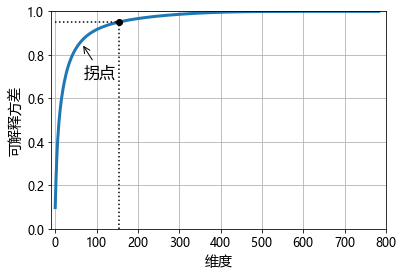

In [16]:
plt.plot(cumsum, linewidth=3)
plt.grid()
plt.axis([-10, 800, 0, 1])
plt.xlabel('维度')
plt.ylabel('可解释方差')
plt.plot([d, d], [0, 0.95], "k:")
plt.plot([0, d], [0.95, 0.95], "k:")
plt.plot(d, 0.95, "ko")
plt.annotate("拐点", xy=(65, 0.85), xytext=(70, 0.7),
             arrowprops=dict(arrowstyle="->"), fontsize=16)
plt.show()

### 简单实现

In [17]:
pca = PCA(n_components=0.95)  # 直接指定要保留的方差率
x_reduced = pca.fit_transform(x_train)

In [18]:
np.shape(x_reduced)

(52500, 154)

## PCA压缩

In [19]:
pca = PCA(n_components=153)
x_reduced = pca.fit_transform(x_train)  # 压缩特征
x_recovered = pca.inverse_transform(x_reduced)  # 解压缩特征，得到重构数据

原始数据与重构数据之间的均方距离成为重构误差

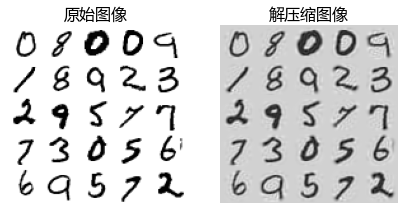

In [20]:
# 展示图像函数
def plot_digits(instances, images_per_row=5, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    # This is equivalent to n_rows = ceil(len(instances) / images_per_row):
    n_rows = (len(instances) - 1) // images_per_row + 1

    # Append empty images to fill the end of the grid, if needed:
    n_empty = n_rows * images_per_row - len(instances)
    padded_instances = np.concatenate([instances, np.zeros((n_empty, size * size))], axis=0)

    # Reshape the array so it's organized as a grid containing 28×28 images:
    image_grid = padded_instances.reshape((n_rows, images_per_row, size, size))

    # Combine axes 0 and 2 (vertical image grid axis, and vertical image axis),
    # and axes 1 and 3 (horizontal axes). We first need to move the axes that we
    # want to combine next to each other, using transpose(), and only then we
    # can reshape:
    big_image = image_grid.transpose(0, 2, 1, 3).reshape(n_rows * size,
                                                         images_per_row * size)
    # Now that we have a big image, we just need to show it:
    plt.imshow(big_image, cmap = mpl.cm.binary, **options)
    plt.axis("off")
    
plt.figure(figsize=(7, 4))
plt.subplot(121)
plot_digits(x_train[::2100])
plt.title("原始图像", fontsize=16)
plt.subplot(122)
plot_digits(x_recovered[::2100])
plt.title("解压缩图像", fontsize=16)
plt.show()

## 随机PCA

它将快速找到前d个主成分的近似值，复杂度为$O(m×d^2)+O(d^3)$而不是完全SVD方法的$O(m×n^2)+O(n^3)$

In [21]:
rnd_pca = PCA(n_components=154, svd_solver='randomized')
# 默认 svd_solver=True，如果m或n大于500并且d小于m或n的80%，则sklearn自动采用随机PCA
# svd_solver=full 强制使用完全SVD

In [22]:
x_reduced = rnd_pca.fit_transform(x_train)

## 增量PCA（IPCA）

前面PCA方法的一个问题是，它们要求整个训练集都放入内存才能运行算法，而增量PCA(IPCA)可以把训练集划分为多个小批量，并一次将一个小批量送入IPCA，对于大型训练集和在线应用PCA很有用

In [23]:
from sklearn.decomposition import IncrementalPCA

n_batches = 100
inc_pca = IncrementalPCA(n_components=154)
for x_batch in np.array_split(x_train, n_batches):  # 分成100份
    inc_pca.partial_fit(x_batch)  # 训练每个部分时必须使用partial_fit()而非fit()

x_reduced = inc_pca.transform(x_train)

## 内核PCA（kPCA）

类似支持向量机的核技巧，rbf, linear, sigmoid等

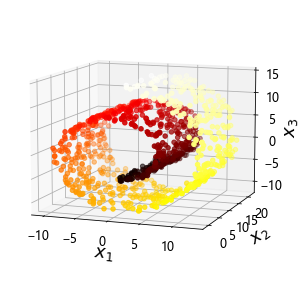

In [24]:
from sklearn.datasets import make_swiss_roll
x, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=42)
axes = [-11.5, 14, -2, 23, -12, 15]

fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(x[:, 0], x[:, 1], x[:, 2], c=t, cmap=plt.cm.hot)
ax.view_init(10, -70)
ax.set_xlabel("$x_1$", fontsize=18)
ax.set_ylabel("$x_2$", fontsize=18)
ax.set_zlabel("$x_3$", fontsize=18)
ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])

plt.show()

In [38]:
from sklearn.decomposition import KernelPCA

rbf_pca = KernelPCA(n_components = 2, kernel="rbf", gamma=0.04)
x_reduced = rbf_pca.fit_transform(x)

## 网格搜索选择内核和参数

In [39]:
x, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=42)
y = t > 6.9

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

clf = Pipeline([
        ("kpca", KernelPCA(n_components=2)),
        ("log_reg", LogisticRegression(solver="lbfgs"))
    ])

param_grid = [{
        "kpca__gamma": np.linspace(0.03, 0.05, 10),
        "kpca__kernel": ["rbf", "sigmoid"]
    }]

grid_search = GridSearchCV(clf, param_grid, cv=3)
grid_search.fit(x, y)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('kpca', KernelPCA(n_components=2)),
                                       ('log_reg', LogisticRegression())]),
             param_grid=[{'kpca__gamma': array([0.03      , 0.03222222, 0.03444444, 0.03666667, 0.03888889,
       0.04111111, 0.04333333, 0.04555556, 0.04777778, 0.05      ]),
                          'kpca__kernel': ['rbf', 'sigmoid']}])

In [40]:
print(grid_search.best_params_)

{'kpca__gamma': 0.043333333333333335, 'kpca__kernel': 'rbf'}


In [46]:
rbf_pca = KernelPCA(n_components=2, kernel='rbf', gamma=0.0433, fit_inverse_transform=True)
# 必须在fit_inverse_transform=True时，KernelPCA才会创建inverse_transform()方法，否则没有
x_reduced = rbf_pca.fit_transform(x)
x_preimage = rbf_pca.inverse_transform(x_reduced)

In [47]:
from sklearn.metrics import mean_squared_error

mean_squared_error(x, x_preimage)  # 输出重构误差

32.78630879576612

利用网格搜索和交叉验证找到可以最大限度减少此错误的内核和超参数

# LLE（局部线性嵌入）

流形(Manifold)是局部具有欧式空间性质的空间，包括各种维度的曲线曲面，例如球体、弯曲的平面等，如瑞士卷，适合展开扭曲的流形，尤其在没有太多噪声的情况下

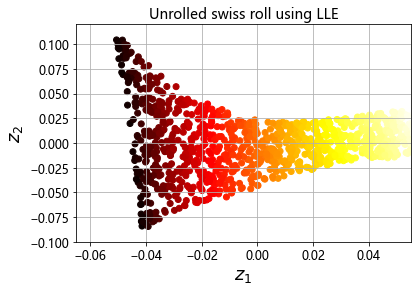

In [50]:
x, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=41)
from sklearn.manifold import LocallyLinearEmbedding
lle = LocallyLinearEmbedding(n_components=2, n_neighbors=10, random_state=42)
x_reduced = lle.fit_transform(x)

plt.title("Unrolled swiss roll using LLE", fontsize=14)
plt.scatter(x_reduced[:, 0], x_reduced[:, 1], c=t, cmap=plt.cm.hot)
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18)
plt.axis([-0.065, 0.055, -0.1, 0.12])
plt.grid(True)

plt.show()  # 可见展开效果相对不错

理想的展开状态 =>

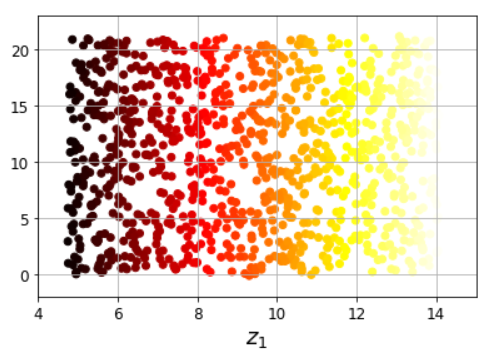

In [51]:
x_reduced

array([[-0.02911379,  0.05697419],
       [-0.04602579,  0.06450202],
       [ 0.01955172, -0.02685072],
       ...,
       [ 0.049233  ,  0.03084511],
       [-0.03588968, -0.01670852],
       [ 0.0474084 ,  0.01104865]])

复杂度 $O(m*ln(m)*n*ln(k))$用于找到k个最近的邻居，$O(mnk^3)$用于优化权重，$O(dm^2)$用于构造低维表示。不幸的是，最后一项的平方项使得该算法很难拓展到非常大的数据集。

# Sklearn的其他降维技术

1. 随机投影
2. 多维缩放（MDS）
3. Isomap
4. t分布随机近邻嵌入（t-SNE）
5. 线性判别分析（LDA）

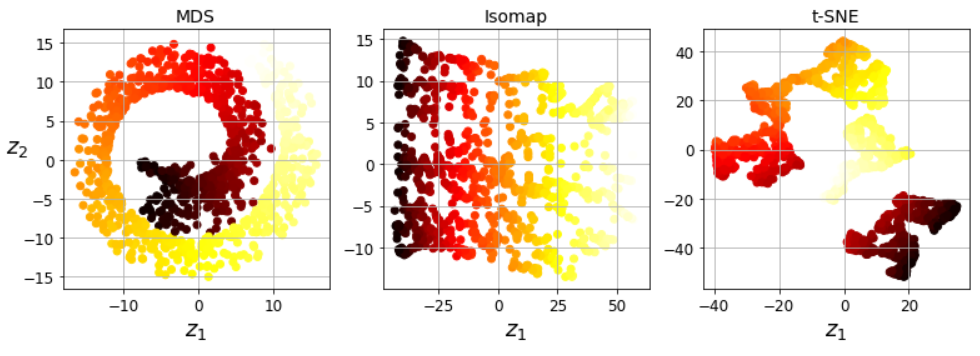